# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [9]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [10]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

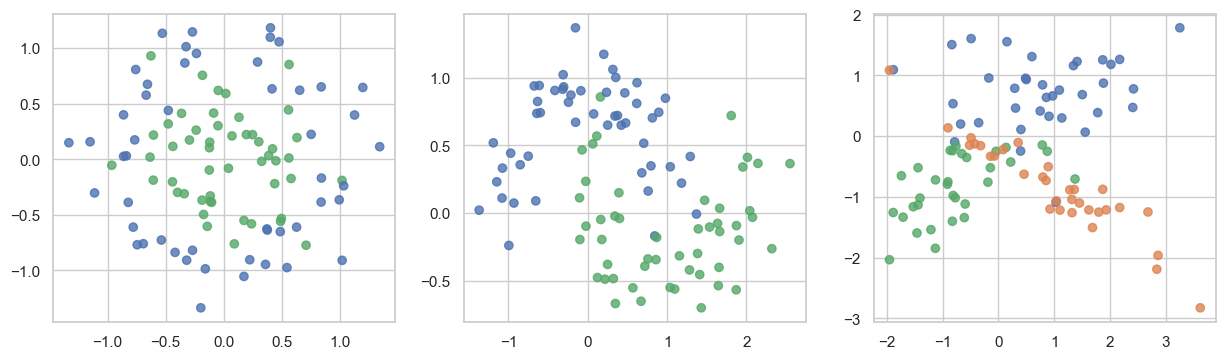

In [11]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [12]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

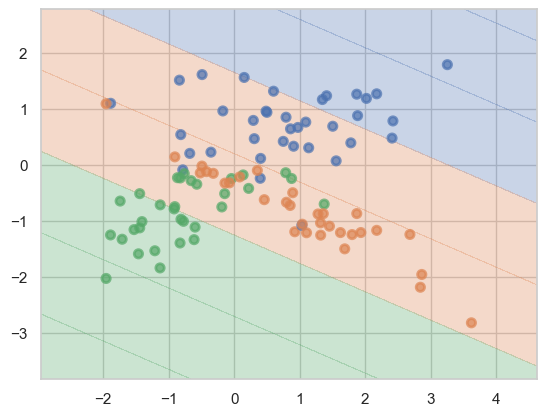

In [13]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

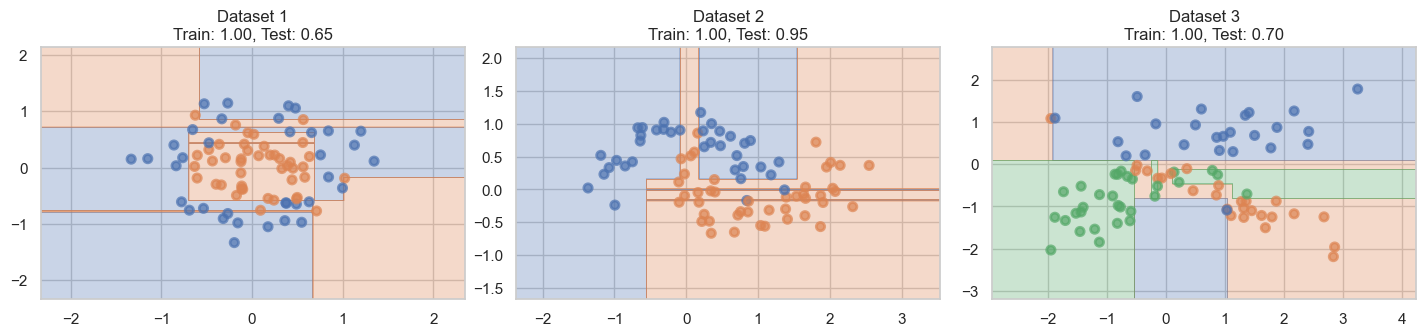

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

plt.figure(figsize=(15, 4))
for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(X_train, y_train)
    
    plt.subplot(1, 3, i + 1)
    plot_surface(dt, X_train, y_train)
    train_acc = accuracy_score(y_train, dt.predict(X_train))
    test_acc = accuracy_score(y_test, dt.predict(X_test))
    plt.title(f"Dataset {i+1}\nTrain: {train_acc:.2f}, Test: {test_acc:.2f}")

plt.show()

__Ответ:__

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

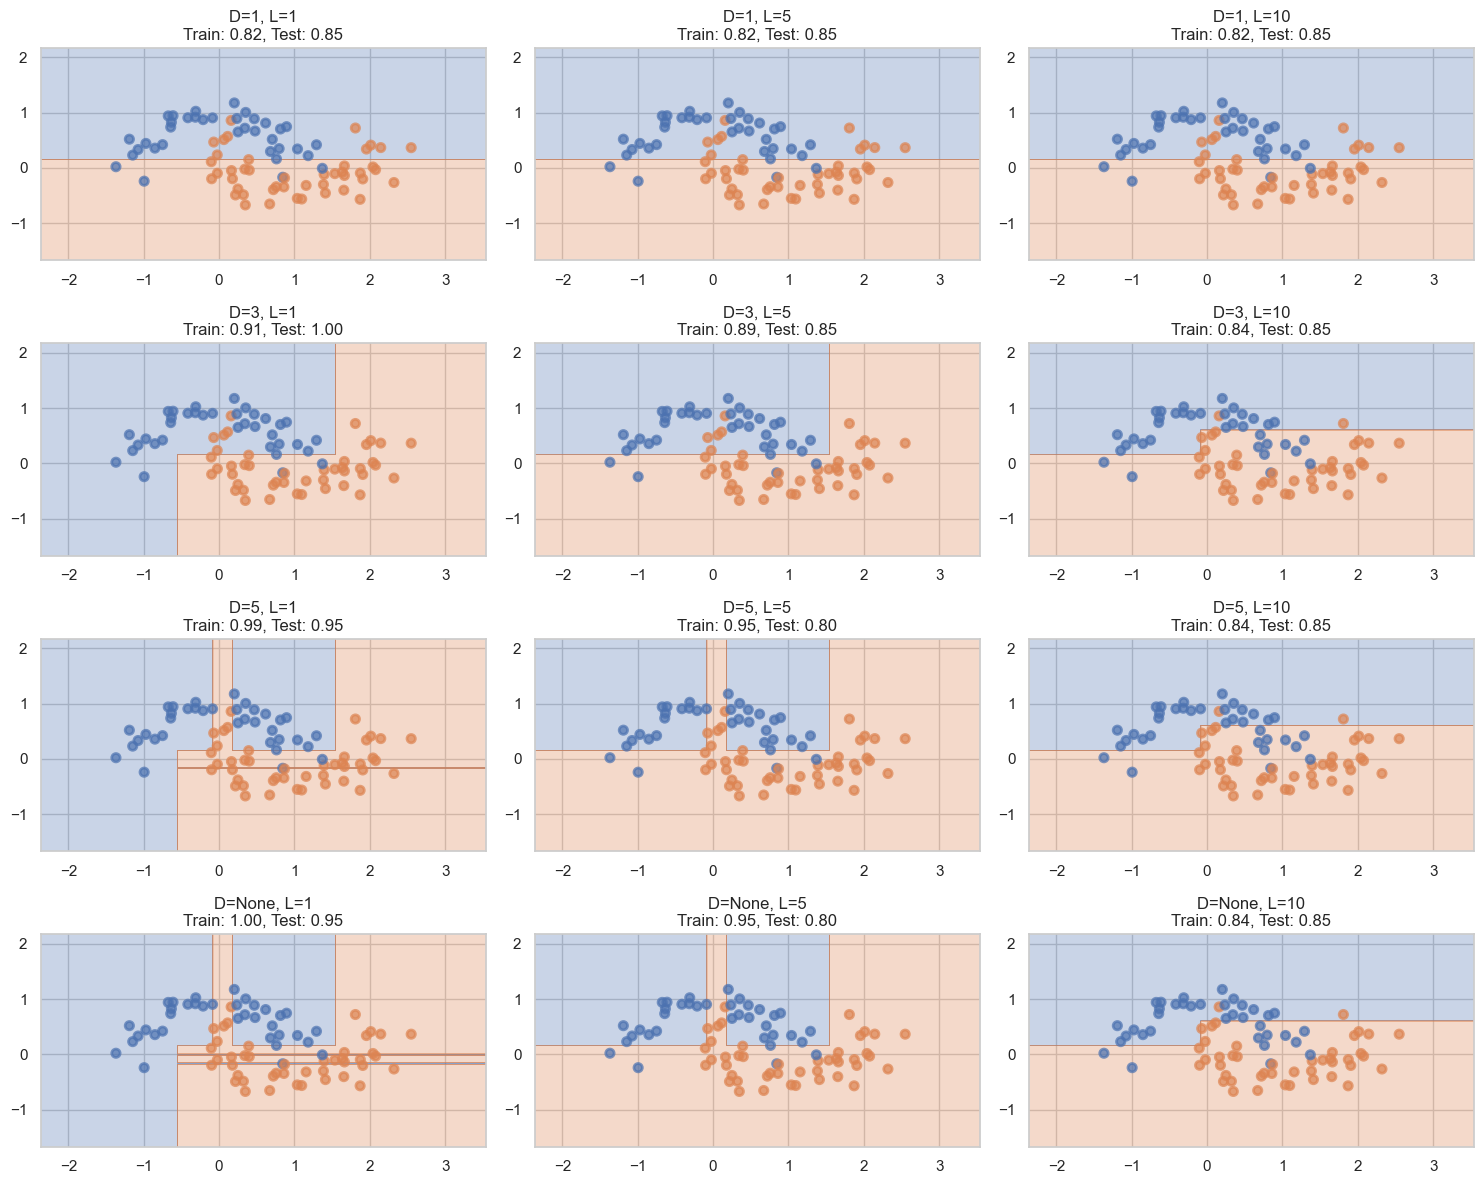

In [15]:
X, y = datasets[1] # Moons
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_depths = [1, 3, 5, None]
min_samples_leafs = [1, 5, 10]

plt.figure(figsize=(15, 12))
plot_idx = 1

for max_depth in max_depths:
    for min_samples_leaf in min_samples_leafs:
        dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        dt.fit(X_train, y_train)
        
        plt.subplot(len(max_depths), len(min_samples_leafs), plot_idx)
        plot_surface(dt, X_train, y_train)
        train_acc = accuracy_score(y_train, dt.predict(X_train))
        test_acc = accuracy_score(y_test, dt.predict(X_test))
        plt.title(f"D={max_depth}, L={min_samples_leaf}\nTrain: {train_acc:.2f}, Test: {test_acc:.2f}")
        plot_idx += 1

plt.tight_layout()
plt.show()

__Ответ:__

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

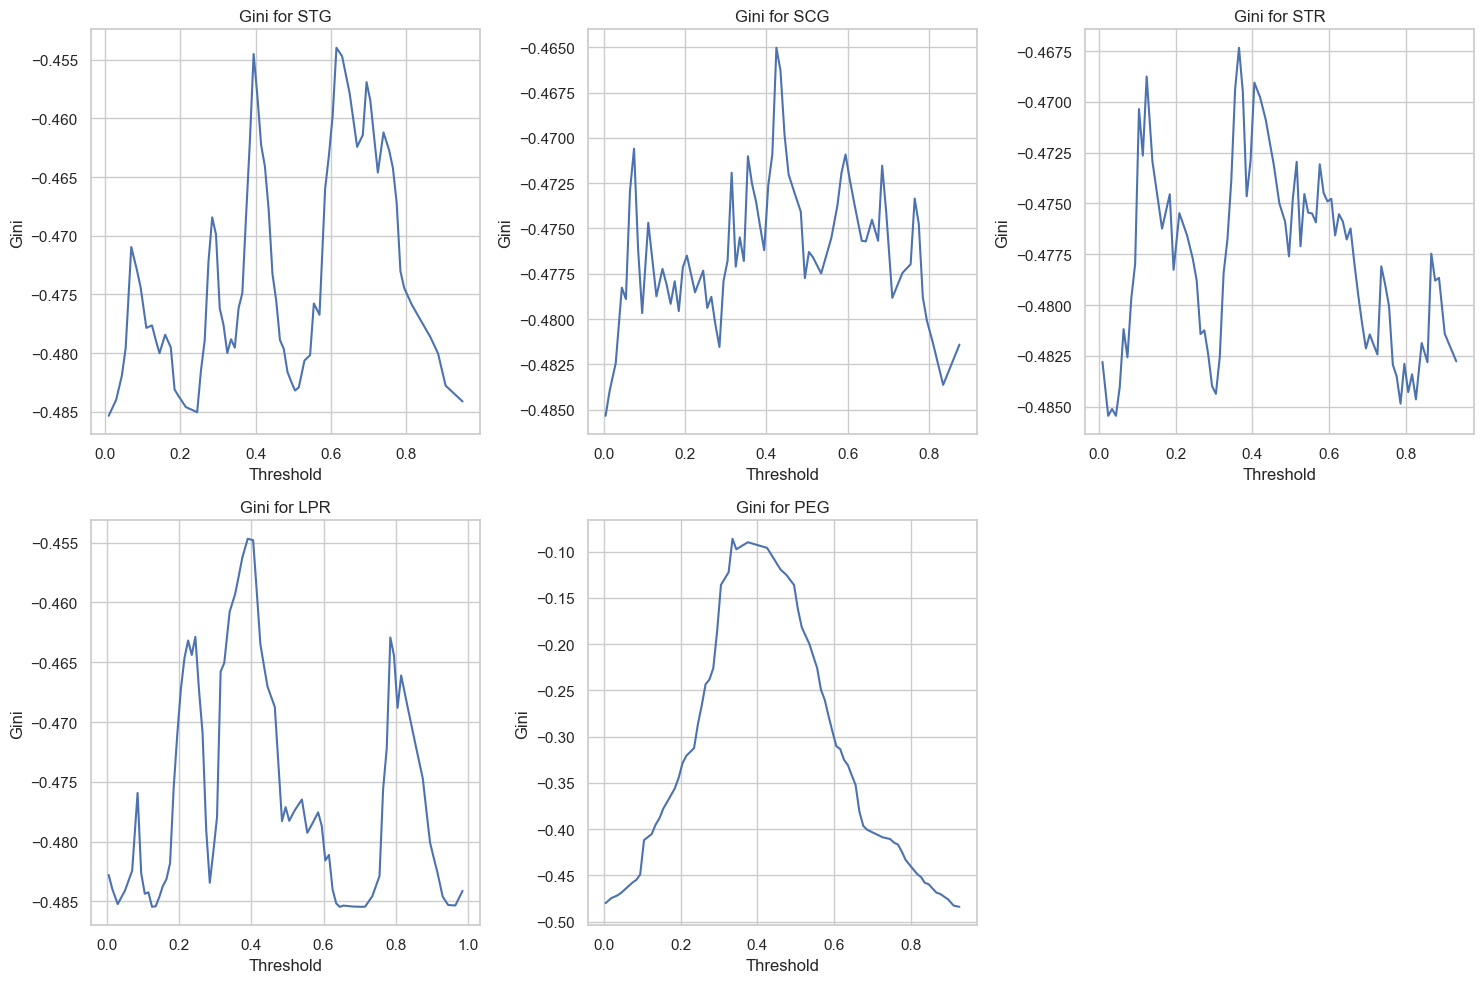

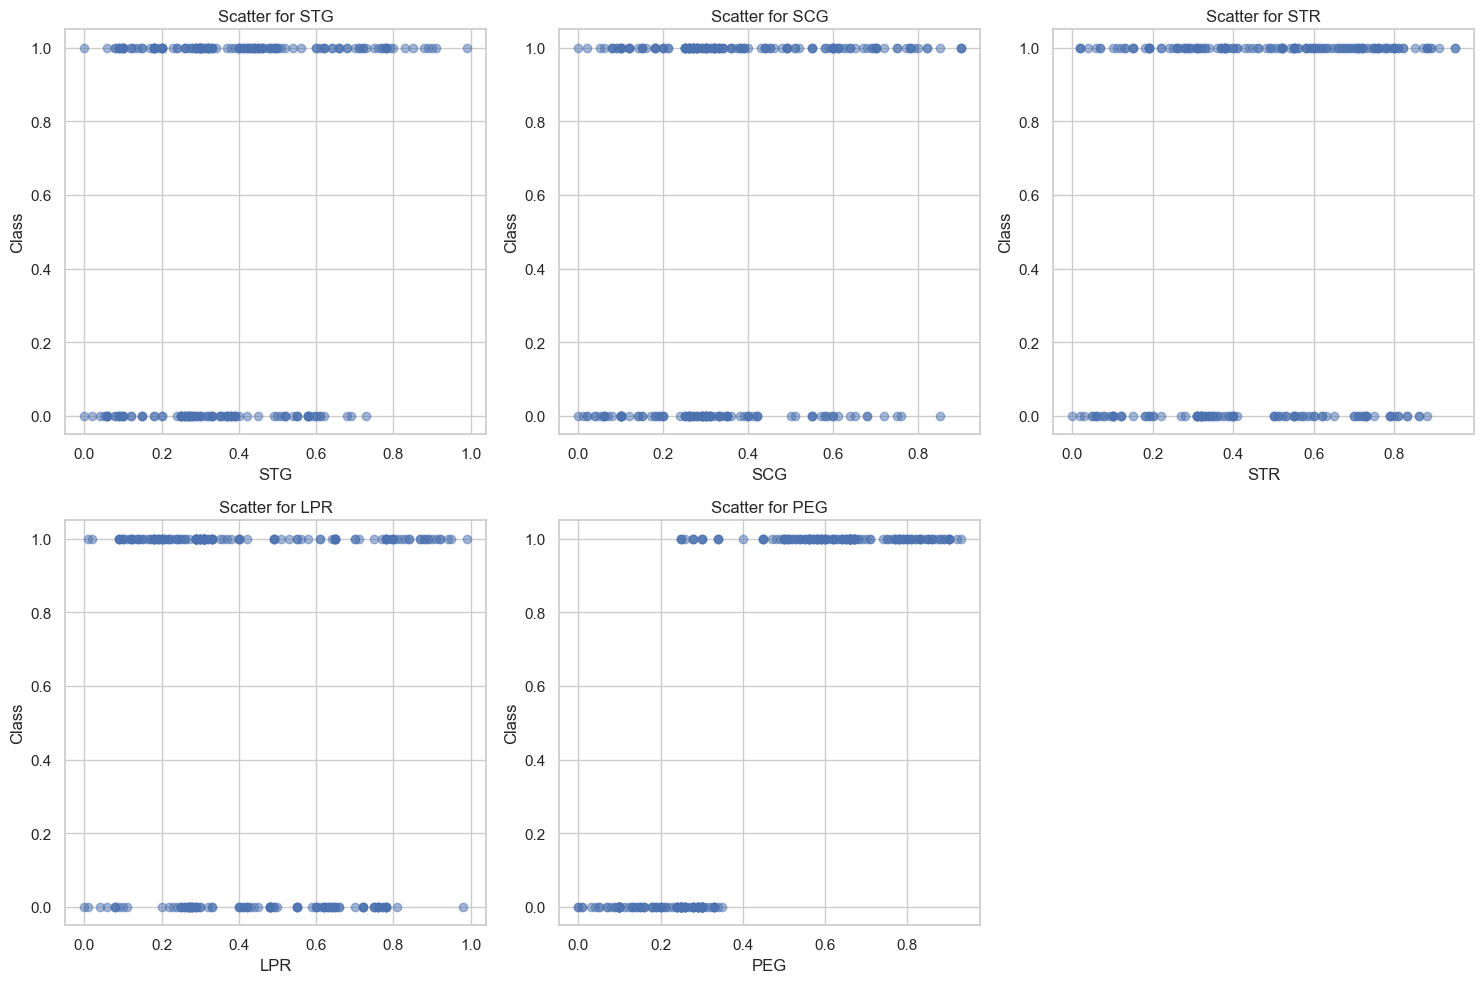

In [16]:
from hw2code import find_best_split

students = pd.read_csv('datasets/students.csv')
y = students['UNS'].values
X = students.drop('UNS', axis=1)

plt.figure(figsize=(15, 10))

for i, col in enumerate(X.columns):
    feature_vector = X[col].values
    thresholds, ginis, _, _ = find_best_split(feature_vector, y)
    
    plt.subplot(2, 3, i + 1)
    plt.plot(thresholds, ginis)
    plt.title(f"Gini for {col}")
    plt.xlabel("Threshold")
    plt.ylabel("Gini")

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    plt.subplot(2, 3, i + 1)
    plt.scatter(X[col], y, alpha=0.5)
    plt.title(f"Scatter for {col}")
    plt.xlabel(col)
    plt.ylabel("Class")

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

Лучшее разделение даёт признак `PEG`: его кривая Джини имеет отчётливый минимум при пороге ≈0.33 и наибольшее (по модулю наименьшее) значение критерия, что соответствует почти чистым листам. Scatter-график для `PEG` подтверждает это — классы чётко разъезжаются вдоль оси признака, и выборку можно отделить одним порогом.

У «хороших» признаков кривая Джини выглядит как узкий «провал» почти до нуля и резко растёт по обе стороны: это отражает, что небольшой диапазон порогов даёт чистые подвыборки. У слабых признаков кривая почти плоская и лежит далеко от нуля — как ни двигай порог, доли классов в листьях почти не меняются, что видно и по scatter-графикам (точки обоих классов смешаны вдоль всей оси признака).

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [17]:
from hw2code import DecisionTree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

df = pd.read_csv('datasets/agaricus-lepiota.data', header=None)
y = df[0].values
X = df.drop(0, axis=1)

le_y = LabelEncoder()
y = le_y.fit_transform(y)

for col in X.columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]
dt = DecisionTree(feature_types)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 1.0000


__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

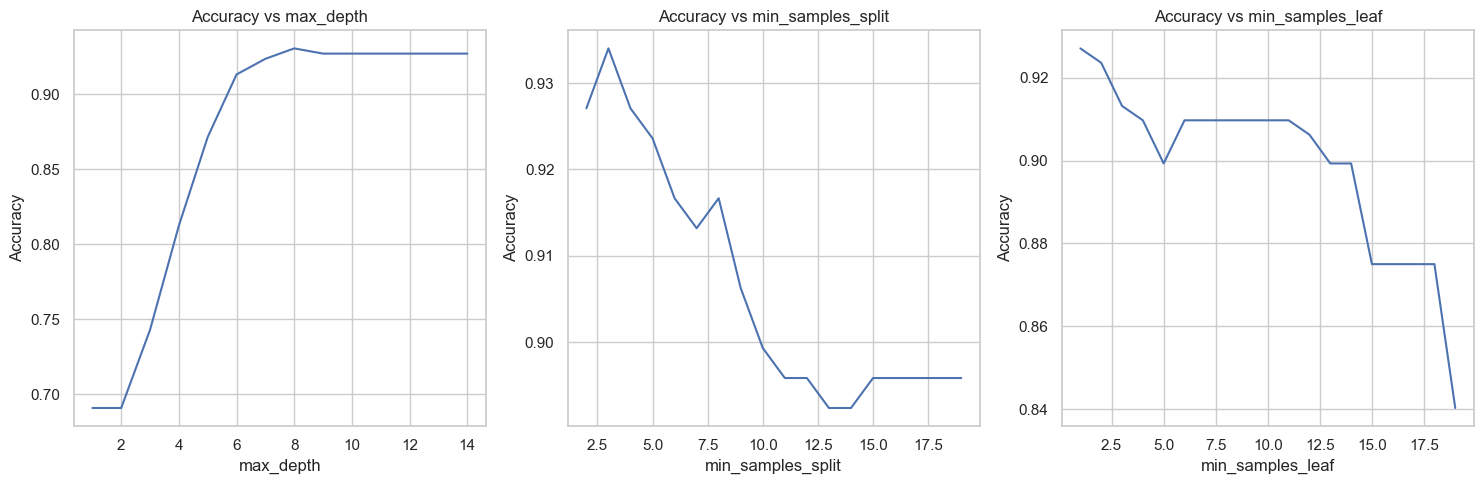

In [18]:
# Task 8
df = pd.read_csv('datasets/tic-tac-toe-endgame.csv')
y = df['V10'].values
X = df.drop('V10', axis=1)

le = LabelEncoder()
y = le.fit_transform(y)
for col in X.columns:
    X[col] = le.fit_transform(X[col])
X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
feature_types = ['categorical'] * X.shape[1]

# Varying max_depth
depths = range(1, 15)
scores_depth = []
for d in depths:
    dt = DecisionTree(feature_types, max_depth=d)
    dt.fit(X_train, y_train)
    scores_depth.append(accuracy_score(y_test, dt.predict(X_test)))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(depths, scores_depth)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs max_depth')

# Varying min_samples_split
splits = range(2, 20)
scores_split = []
for s in splits:
    dt = DecisionTree(feature_types, min_samples_split=s)
    dt.fit(X_train, y_train)
    scores_split.append(accuracy_score(y_test, dt.predict(X_test)))

plt.subplot(1, 3, 2)
plt.plot(splits, scores_split)
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Accuracy vs min_samples_split')

# Varying min_samples_leaf
leafs = range(1, 20)
scores_leaf = []
for l in leafs:
    dt = DecisionTree(feature_types, min_samples_leaf=l)
    dt.fit(X_train, y_train)
    scores_leaf.append(accuracy_score(y_test, dt.predict(X_test)))

plt.subplot(1, 3, 3)
plt.plot(leafs, scores_leaf)
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy vs min_samples_leaf')

plt.tight_layout()
plt.show()

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [19]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin

# Datasets
datasets_info = {
    'mushrooms': 'datasets/agaricus-lepiota.data',
    'tic-tac-toe': 'datasets/tic-tac-toe-endgame.csv',
    'cars': 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data',
    'nursery': 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data'
}

results = pd.DataFrame(index=['mushrooms', 'tic-tac-toe', 'cars', 'nursery'], 
                       columns=['DT (Real)', 'DT (Cat)', 'DT (Real+OHE)', 'Sklearn DT'])


def load_dataset(name):
    if name == 'mushrooms':
        df = pd.read_csv('datasets/agaricus-lepiota.data', header=None)
        y = df[0]
        X = df.drop(0, axis=1)
    elif name == 'tic-tac-toe':
        df = pd.read_csv('datasets/tic-tac-toe-endgame.csv')
        y = df['V10']
        X = df.drop('V10', axis=1)
    elif name == 'cars':
        df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
        y = df[6]
        X = df.drop(6, axis=1)
        y = y.replace({'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1})
    elif name == 'nursery':
        df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)
        y = df[8]
        X = df.drop(8, axis=1)
        y = y.replace({'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1})

    le = LabelEncoder()
    y = le.fit_transform(y)

    X_enc = X.copy()
    for col in X.columns:
        X_enc[col] = le.fit_transform(X[col].astype(str))

    return X_enc, y


class MyDecisionTreeWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, feature_types, max_depth=None, min_samples_split=None, min_samples_leaf=None):
        self.feature_types = feature_types
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def fit(self, X, y):
        self.tree = DecisionTree(self.feature_types, self.max_depth, self.min_samples_split, self.min_samples_leaf)
        self.tree.fit(X, y)
        return self

    def predict(self, X):
        return self.tree.predict(X)


for name in results.index:
    print(f"Processing {name}...")
    try:
        X, y = load_dataset(name)

        # 1. DT (Real)
        ft_real = ['real'] * X.shape[1]
        dt_real = MyDecisionTreeWrapper(feature_types=ft_real)
        score_real = np.mean(cross_val_score(dt_real, X.values, y, cv=10, scoring='accuracy'))
        results.loc[name, 'DT (Real)'] = score_real

        # 2. DT (Cat)
        ft_cat = ['categorical'] * X.shape[1]
        dt_cat = MyDecisionTreeWrapper(feature_types=ft_cat)
        score_cat = np.mean(cross_val_score(dt_cat, X.values, y, cv=10, scoring='accuracy'))
        results.loc[name, 'DT (Cat)'] = score_cat

        # 3. DT (Real + OHE)
        ohe = OneHotEncoder(sparse_output=False)
        X_ohe = ohe.fit_transform(X)
        ft_ohe = ['real'] * X_ohe.shape[1]
        dt_ohe = MyDecisionTreeWrapper(feature_types=ft_ohe)
        score_ohe = np.mean(cross_val_score(dt_ohe, X_ohe, y, cv=10, scoring='accuracy'))
        results.loc[name, 'DT (Real+OHE)'] = score_ohe

        # 4. Sklearn DT
        dt_sklearn = DecisionTreeClassifier()
        score_sklearn = np.mean(cross_val_score(dt_sklearn, X, y, cv=10, scoring='accuracy'))
        results.loc[name, 'Sklearn DT'] = score_sklearn

    except Exception as e:
        print(f"Error processing {name}: {e}")

results

Processing mushrooms...
Processing tic-tac-toe...
Processing tic-tac-toe...
Processing cars...
Processing cars...
Processing nursery...
Processing nursery...


,DT (Real),DT (Cat),DT (Real+OHE),Sklearn DT
mushrooms,0.999261,1.0,0.999631,0.961123
tic-tac-toe,0.467533,0.541458,0.543575,0.787325
cars,0.942647,0.967546,0.919495,0.943285
nursery,0.999691,0.999846,0.999537,0.999691


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Результаты для разных датасетов отличаются. На `mushrooms` и `nursery` почти все алгоритмы дают очень высокую точность, но дерево с категориальными признаками работает чуть лучше. На `cars` тоже лучше всего работает дерево с категориальными признаками, а one-hot кодирование немного ухудшает результат. На `tic-tac-toe` лучший результат у дерева из sklearn, потому что оно по-другому выбирает признаки и параметры.

На результаты влияет случайность: разбиение на части для проверки и случайные параметры в дереве.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

![image.png](pic.png)